In [1]:
%cd ..

/home/soda/rcappuzz/work/prepare-data-lakes


In [2]:
%load_ext autoreload
%autoreload 2
import src.yago.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
import pandas as pd
import polars as pl
from pathlib import Path
import numpy as np

In [4]:
yago_path = Path("/storage/store3/work/jstojano/yago3/")
facts1_path = Path(yago_path, "facts_parquet/yago_updated_2022_part1")
facts2_path = Path(yago_path, "facts_parquet/yago_updated_2022_part2")

## Reading yago triplets

In [5]:
fname = "yagoFacts"
yagofacts_path = Path(facts2_path, f"{fname}.tsv.parquet")
yagofacts = utils.import_from_yago(yagofacts_path, engine="polars")

In [6]:
fname = "yagoTypes"
yagotypes_path = Path(facts1_path, f"{fname}.tsv.parquet")
yagotypes = utils.import_from_yago(yagotypes_path, engine="polars")


## Some profiling

### Predicates

In [7]:
unique_facts = utils.find_unique_predicates(yagofacts)
print(unique_facts)

shape: (37, 1)
┌───────────────────────┐
│ predicate             │
│ ---                   │
│ str                   │
╞═══════════════════════╡
│ <hasCurrency>         │
│ <hasChild>            │
│ <edited>              │
│ <directed>            │
│ …                     │
│ <isLeaderOf>          │
│ <actedIn>             │
│ <isKnownFor>          │
│ <hasOfficialLanguage> │
└───────────────────────┘


These predicates will be used as `attributes` in the wide-form version of YAGO. 

In [8]:
count_facts=utils.count_occurrences_by_columns(yagofacts, "predicate")
print(count_facts)

shape: (37, 2)
┌───────────────────────┬─────────┐
│ predicate             ┆ count   │
│ ---                   ┆ ---     │
│ str                   ┆ u32     │
╞═══════════════════════╪═════════╡
│ <isLocatedIn>         ┆ 3289399 │
│ <isCitizenOf>         ┆ 2390826 │
│ <hasGender>           ┆ 2016273 │
│ <isAffiliatedTo>      ┆ 1569882 │
│ …                     ┆ …       │
│ <hasOfficialLanguage> ┆ 989     │
│ <exports>             ┆ 714     │
│ <hasNeighbor>         ┆ 598     │
│ <imports>             ┆ 481     │
└───────────────────────┴─────────┘


Selecting only the top 10 facts to work with. 

In [9]:
top10facts = count_facts.head(10)

### Types

In [10]:
unique_types = utils.count_occurrences_by_columns(yagotypes, "cat_object")

In [11]:
unique_types.head(10)

cat_object,count
str,u32
"""<wordnet_perso...",2034731
"""<wikicat_Livin...",1034138
"""<wordnet_admin...",470161
"""<wordnet_offic...",169553
"""<wordnet_album...",156553
"""<wordnet_movie...",151678
"""<wordnet_artis...",140435
"""<wordnet_seaso...",106211
"""<wordnet_compa...",81358


While looking at entity types, count the number of types each entity has and select the first for each of them. 

In [12]:
first_type = (yagotypes.lazy().groupby(
    "subject"
).agg(
    [
        pl.first("cat_object"),
        pl.count()
    ]
).sort("count", descending=True).collect())

print(first_type.head(20))

shape: (20, 3)
┌───────────────────────────────────┬───────────────────────────────────┬───────┐
│ subject                           ┆ cat_object                        ┆ count │
│ ---                               ┆ ---                               ┆ ---   │
│ str                               ┆ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════════════════════════════════╪═══════╡
│ <First_Geneva_Convention>         ┆ <wikicat_Treaties_of_Indonesia>   ┆ 244   │
│ <Third_Geneva_Convention>         ┆ <wikicat_Treaties_of_the_Marshal… ┆ 243   │
│ <Second_Geneva_Convention>        ┆ <wikicat_Treaties_of_Indonesia>   ┆ 242   │
│ <Fourth_Geneva_Convention>        ┆ <wikicat_Treaties_of_the_Marshal… ┆ 241   │
│ …                                 ┆ …                                 ┆ …     │
│ <Protection_of_Diplomats_Convent… ┆ <wikicat_Treaties_of_Indonesia>   ┆ 218   │
│ <Treaty_on_the_Non-Proliferation… ┆ <wikicat_Treaties_of_the_Marshal… ┆ 217   │
│

Looking at the wiki page of the [First Geneva Convention](https://en.wikipedia.org/wiki/First_Geneva_Convention), it seems
that types have much smaller granularity than I had expected. I should probably focus only on the most frequent types 
and ignore others. 

Out of curiosity, let's plot the distribution of types and see what it looks like. 

(1, 1000000.0)

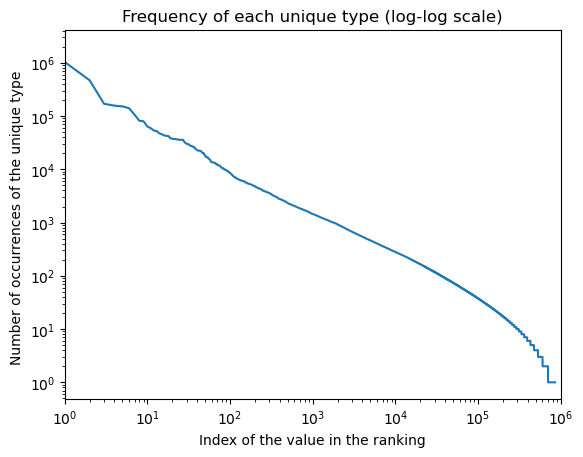

In [207]:
data=unique_types["count"]
ax = sns.lineplot(data=data)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Frequency of each unique type (log-log scale)")
ax.set_xlabel("Index of the value in the ranking")
ax.set_ylabel("Number of occurrences of the unique type ")
ax.set_xlim([1, 1e6])

Now I'm considering only the top 10 types, i.e. the 10 most frequent types. 

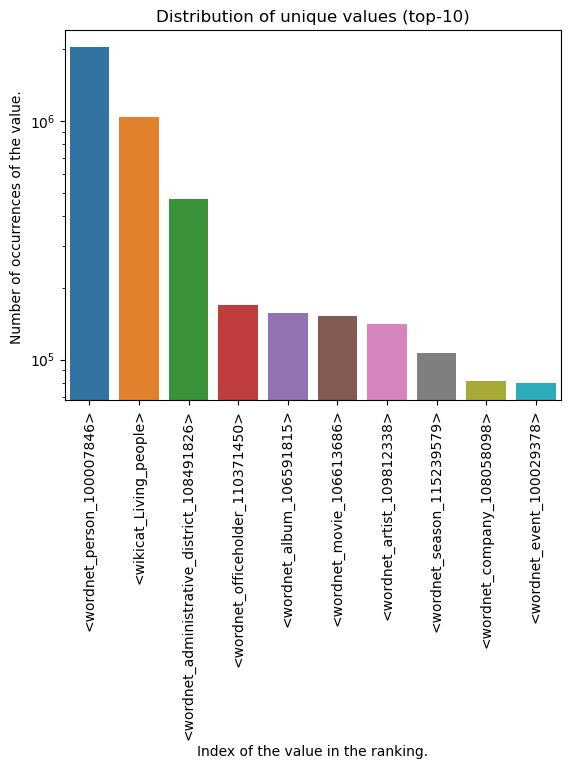

In [212]:
top10types=unique_types[:10]
data=top10types["count"].to_pandas().reset_index()
ax = sns.barplot(data=data, x="index", y="count")
ax.set_yscale("log")
ax.set_title("Distribution of unique values (top-10)")
ax.set_xlabel("Index of the value in the ranking.")
ax.set_ylabel("Number of occurrences of the value. ")
_=ax.set_xticks(ticks=range(10),labels=top10types["cat_object"], rotation=90)

The two cells below (should) have the same output, but the execution time differs quite a lot. I am not sure why this is
the case.

In [216]:
most_frequent_types=(yagotypes.lazy().filter(
    pl.col("cat_object").is_in(top10types["cat_object"])
).groupby("subject").agg(
    pl.first()
).select(pl.col("subject")).collect())

In [217]:
yagotypes.lazy().filter(
    pl.col("cat_object").is_in(top10types["cat_object"])
).select(
    pl.col("subject").unique()
).collect()

subject
str
"""<Bindé_Departm..."
"""<Thomas_MacLea..."
"""<Win_Ng>"""
"""<Tom_Freestone..."
"""<National_Pict..."
"""<Alive_(Nitty_..."
"""<2003_New_York..."
"""<Derek_Brazil>..."
"""<William_Walle..."


## Filter facts to include only frequent types

Here I am filtering the subjects to keep only those whose type is in `most_frequent_types`. 

In [218]:
yagofacts_frequenttypes=(yagofacts.lazy().filter(
    pl.col("subject").is_in(most_frequent_types["subject"])
).collect())

In [219]:
pair_tab_list = []
groups = yagofacts_frequenttypes.groupby("predicate")
for group_name, group in groups:
    print(group_name)
    pair_tab=group.select(
    [    pl.col("subject").alias("subject"),
        pl.col("cat_object").alias(group_name),
    ])
    pair_tab_list.append(pair_tab)

<hasCapital>
<isAffiliatedTo>
<actedIn>
<livesIn>
<wroteMusicFor>
<isMarriedTo>
<hasOfficialLanguage>
<hasWebsite>
<hasWonPrize>
<isLeaderOf>
<participatedIn>
<edited>
<graduatedFrom>
<worksAt>
<hasCurrency>
<hasGender>
<isCitizenOf>
<isLocatedIn>
<influences>
<playsFor>
<isKnownFor>
<hasAcademicAdvisor>
<owns>
<happenedIn>
<isPoliticianOf>
<hasMusicalRole>
<isConnectedTo>
<dealsWith>
<directed>
<imports>
<wasBornIn>
<diedIn>
<hasChild>
<created>
<isInterestedIn>
<exports>


Here I am executing a self-join on `yagofacts_frequenttypes` to generate pairs of `predicate`s: these are the cases in 
which one `subject` has multiple `predicate`s, and these predicates co-occur. 

The reason why I am extracting these pairs is because this ensures that I can build tables by joining on the `subject`. 

In [220]:
cooccurring_predicates=(yagofacts_frequenttypes.lazy().join(
    yagofacts_frequenttypes.lazy(), left_on="subject",
    right_on="subject", how="left"
).select(
    [
        pl.col("predicate"),
        pl.col("predicate_right")
    ]
).groupby("predicate_right").agg(
    pl.first("predicate")
).collect())

In [222]:
cooccurring_predicates.head(10)

predicate_right,predicate
str,str
"""<hasWonPrize>""","""<isLeaderOf>"""
"""<hasChild>""","""<isLeaderOf>"""
"""<happenedIn>""","""<isLocatedIn>"""
"""<influences>""","""<isLeaderOf>"""
"""<isInterestedI...","""<isLeaderOf>"""
"""<imports>""","""<owns>"""
"""<hasWebsite>""","""<isLeaderOf>"""
"""<hasGender>""","""<isLeaderOf>"""
"""<isMarriedTo>""","""<isLeaderOf>"""


## Plotting co-occurring pairs

Here I am trying to build a histogram that shows the pairs of columns that appear together the most, and those that never
co-occur. First off, I am looking for "at least one co-occurrence". As I'll show later, this is not very insightful 
because there is a huge variance in the co-occurrence frequency. 

In [225]:
sample_cooccurring=(yagofacts_frequenttypes.lazy().join(
    yagofacts_frequenttypes.lazy(), left_on="subject",
    right_on="subject", how="left"
).select(
    [
        pl.col("predicate"),
        pl.col("predicate_right")
    ]
).groupby(
    [
        "predicate",
        "predicate_right"
    ]
).all().collect())

In [228]:
sample_cooccurring

predicate,predicate_right
str,str
"""<diedIn>""","""<isAffiliatedT..."
"""<hasCurrency>""","""<hasCurrency>"""
"""<isLeaderOf>""","""<graduatedFrom..."
"""<hasCurrency>""","""<hasOfficialLa..."
"""<hasWonPrize>""","""<isKnownFor>"""
"""<hasAcademicAd...","""<isInterestedI..."
"""<diedIn>""","""<wasBornIn>"""
"""<hasGender>""","""<diedIn>"""
"""<directed>""","""<influences>"""


/storage/workspace/tmp/ipykernel_12692/1427728332.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


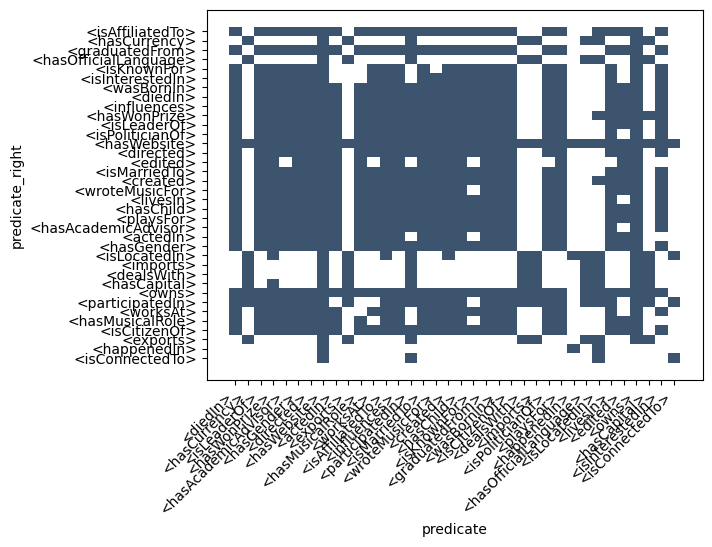

In [240]:
ax = sns.histplot(data=sample_cooccurring, x="predicate", y="predicate_right", )
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In the next cells, I will be executing the same self-join as above, however I am not executing the aggregation: by doing
this I am saving all the combinations of predicates. 

In [241]:
cooccurring_predicates=(yagofacts_frequenttypes.lazy().join(
    yagofacts_frequenttypes.lazy(), left_on="subject",
    right_on="subject", how="left"
).select(
    [
        pl.col("predicate"),
        pl.col("predicate_right")
    ]
).collect())

The size of this self-join is pretty large.

In [246]:
cooccurring_predicates.shape

(152441548, 2)

Then, I am counting the number of occurrences of each pair of predicates. 

In [242]:
count_cooccurring_predicates=(cooccurring_predicates.lazy().groupby(
    ["predicate","predicate_right"]
).agg(
    pl.count()
).sort("count", descending=True).collect())

Finally, I am plotting the frequencies (y-axis has log-scale).

Text(0, 0.5, 'Number of occurrences of the predicate.')

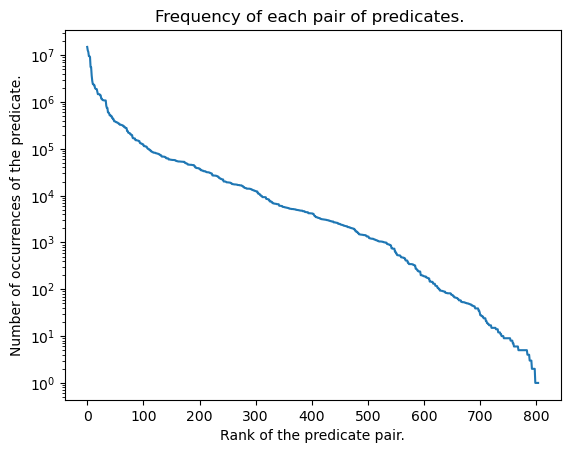

In [243]:
ax = sns.lineplot(data=count_cooccurring_predicates, x=range(len(count_cooccurring_predicates)),y="count")
ax.set_yscale("log")
ax.set_title("Frequency of each pair of predicates. ")
ax.set_xlabel("Rank of the predicate pair.")
ax.set_ylabel("Number of occurrences of the predicate.")

### Preparing a pairwise heatmap
I was not able to figure out a direct way of generating a heatmap that would take pairs of strings as x- and y- coordinates, 
as well as a given value for the cell. 

To get around this, I converted the strings to Pandas Categories, then used their indices to create the heatmap. 

In [247]:
sample_count=count_cooccurring_predicates
sample_count_pd = sample_count.to_pandas()

In [248]:
sample_count_pd[["predicate", "predicate_right"]]=sample_count_pd[["predicate", "predicate_right"]].astype("category")
sample_count_pd[["predicate_int", "predicate_right_int"]]=sample_count_pd[["predicate", "predicate_right"]].apply(lambda x: x.cat.codes)
max_category = sample_count_pd[[
    "predicate_int",
    "predicate_right_int"
]].max().max()

In [250]:
# Set the proper coordinates
zz= np.zeros((max_category+1,max_category+1))
zz[sample_count_pd["predicate_int"], sample_count_pd["predicate_right_int"]] = sample_count_pd["count"]
# Set the proper labels
dd = dict(sorted(dict( zip( sample_count_pd['predicate'].cat.codes, sample_count_pd['predicate'] ) ).items()))

As the plot above attests, there is a huge difference in the number of occurrences of each pair: the most frequent pairs
are found millions of times, the least frequent pairs appear as few as once. 

To account for this, the heatmap has a log-normalized color bar.

Text(0.5, 1.0, 'Frequency of co-occurrence of predicate pairs in frequent values')

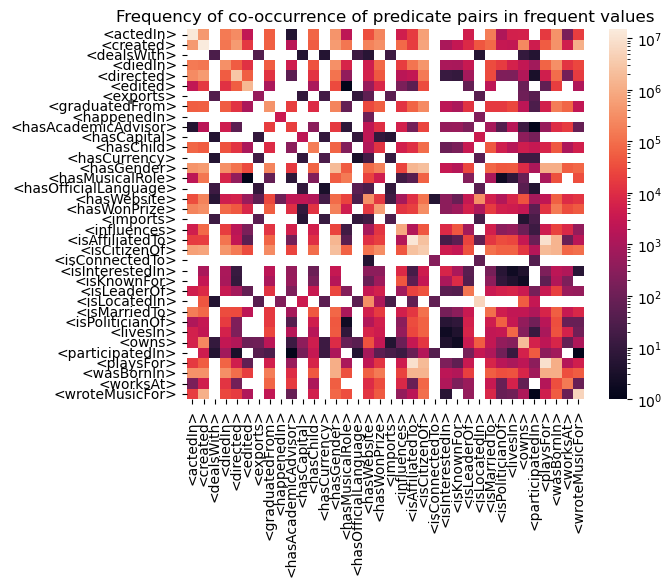

In [253]:
from matplotlib.colors import LogNorm
norm = LogNorm()
ax = sns.heatmap(zz, robust=True, cmap="rocket", norm=norm, xticklabels=list(dd.values()),yticklabels=list(dd.values()))
ax.set_title("Frequency of co-occurrence of predicate pairs in frequent values")

## Summary

In summary, the operations I carried out are the following:

1. I looked for the most frequent types.
2. I selected the `subjects` that have at least one of those types.
3. I generated all the pairs of `predicates` that could be found among the most frequent values.
4. I plotted some info on those pairs as lineplot and heatmap. 